In [1]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Construct a Recurrent Neural Network for multivariate time series prediction.
2. Run this notebook and record results.
3. Generate prediction and compare with the original timeseries. 
4. Reflect on your experience gained in module 3 on Deep Learning

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Prediction](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

*Provide code to load all required Python libraries (e.g. pandas, tensorflow, keras).*

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import math
import matplotlib.dates as mdates 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, BatchNormalization, LSTM, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1,l2,l1_l2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Provide code to define any common functions (e.g. output format, plot) that you will use below.*

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [10, 5]

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [5]:
#Collect history

# Initiates collections of model performance
def start_hist():
    return {}

# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

In [6]:
#Plot history
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

In [7]:
#Batch generator for training
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-events.
        x_shape = (batch_size, sequence_length, num_x_events)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-events.
        y_shape = (batch_size, sequence_length, num_y_events)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [8]:
# The shape of both input tensors are: [batch_size, sequence_length, num_y_events]
def loss_mse_warmup(y_true, y_pred):
    # Ignore the "warmup" parts of the sequences
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))   
    return mse

In [9]:
def plot_batch(x_batch,y_batch,batch=0,column=0):
    try:
        x_seq = x_batch[batch, :, column]
        y_seq = y_batch[batch, :, 0]
        plt.plot(x_seq)
        plt.plot(y_seq)
        plt.title('Time Series Batch: Training (past) vs Labels (future)')
        plt.ylabel('Measurement')
        plt.xlabel('Time')
        plt.legend(['Training (x)', 'Labels (y)'], loc='upper left')
    except:
      print("batch and columns cannot be greater than 29 and 7 respectively")

In [10]:
# Plot the predicted and true output-events.

def plot_comparison(start_idx, length=100, xlim=None, ylim=None, model = 'model'):
    """
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    # Use training-data.
    x = np.row_stack([x_train_scaled,x_val_scaled,x_test_scaled])
    y_true = np.row_stack([y_train,y_val,y_test])
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx].reshape(-1,1)
    
    # Input-events for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-events.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0]).reshape(-1,1)
    
    # For each output-event.
    for event in range(len(target_meas)):
        # Get the output-event predicted by the model.
        event_pred = y_pred_rescaled[:, event]
        
        # Get the true output-event from the data-set.
        event_true = y_true[:, event]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two events.
        plt.plot(event_true, label='true')
        plt.plot(event_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        if (xlim): plt.xlim(xlim)
        if (ylim): plt.ylim(ylim)
        plt.ylabel(target_meas[event])
        plt.legend()
        plt.show()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing.*

In [11]:
stock_data = pd.read_csv('/content/drive/MyDrive/PartC-Stocks.csv')
print('Stock prices data shape: ', stock_data.shape)
print('Date from: ', stock_data['Date'].min(), 'to: ', stock_data['Date'].max())
stock_data.head()

Stock prices data shape:  (2516, 10)
Date from:  1/10/11 12:00 AM to:  9/9/19 12:00 AM


,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
0,1/4/10 12:00 AM,14612,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
1,1/5/10 12:00 AM,14613,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2,1/6/10 12:00 AM,14614,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
3,1/7/10 12:00 AM,14615,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
4,1/8/10 12:00 AM,14616,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858


In [12]:
#Formatting date column as index and dropping date and day column
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.index = stock_data['Date']
stock_data.drop(['Date','Day'],inplace=True,axis=1)
print('Stock data shape:',stock_data.shape)
stock_data.head()

Stock data shape: (2516, 8)


,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
Date,,,,,,,,
2010-01-04,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
2010-01-05,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2010-01-06,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
2010-01-07,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
2010-01-08,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858


In [13]:
#Data statistics
stock_data.describe()

,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,16.078941,652.111853,56.322166,162.001892,32.489364,104.480763,676.207079,110.345293
std,4.776089,328.755875,33.863428,24.271917,10.704391,84.966762,580.440707,56.172958
min,5.317893,218.253250,23.010000,107.570000,17.670000,22.690001,108.610001,27.435715
25%,12.189729,317.869110,29.559999,143.037495,23.257500,34.274999,227.597496,64.714285
50%,15.887779,570.769989,44.400002,159.529999,30.860001,72.904999,375.140015,99.480000
75%,19.865320,947.542480,70.940002,184.007504,36.902501,143.597496,967.847488,150.552502
max,26.420000,1362.469971,158.960007,215.800003,60.080002,331.200012,2039.510010,293.649994


In [14]:
#Checking missing values
stock_data.isnull().sum()

HPQ      0
GOOGL    0
MSFT     0
IBM      0
INTC     0
ADBE     0
AMZN     0
AAPL     0
dtype: int64

In [15]:
## Correlation matrix
corr_mat = stock_data.corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
HPQ,1.00,0.49,0.54,-0.69,0.54,0.58,0.55,0.44
GOOGL,0.49,1.00,0.94,-0.46,0.94,0.95,0.95,0.94
MSFT,0.54,0.94,1.00,-0.50,0.94,0.99,0.98,0.95
IBM,-0.69,-0.46,-0.50,1.00,-0.44,-0.51,-0.49,-0.37
INTC,0.54,0.94,0.94,-0.44,1.00,0.95,0.94,0.94
ADBE,0.58,0.95,0.99,-0.51,0.95,1.00,0.99,0.94
AMZN,0.55,0.95,0.98,-0.49,0.94,0.99,1.00,0.93
AAPL,0.44,0.94,0.95,-0.37,0.94,0.94,0.93,1.00


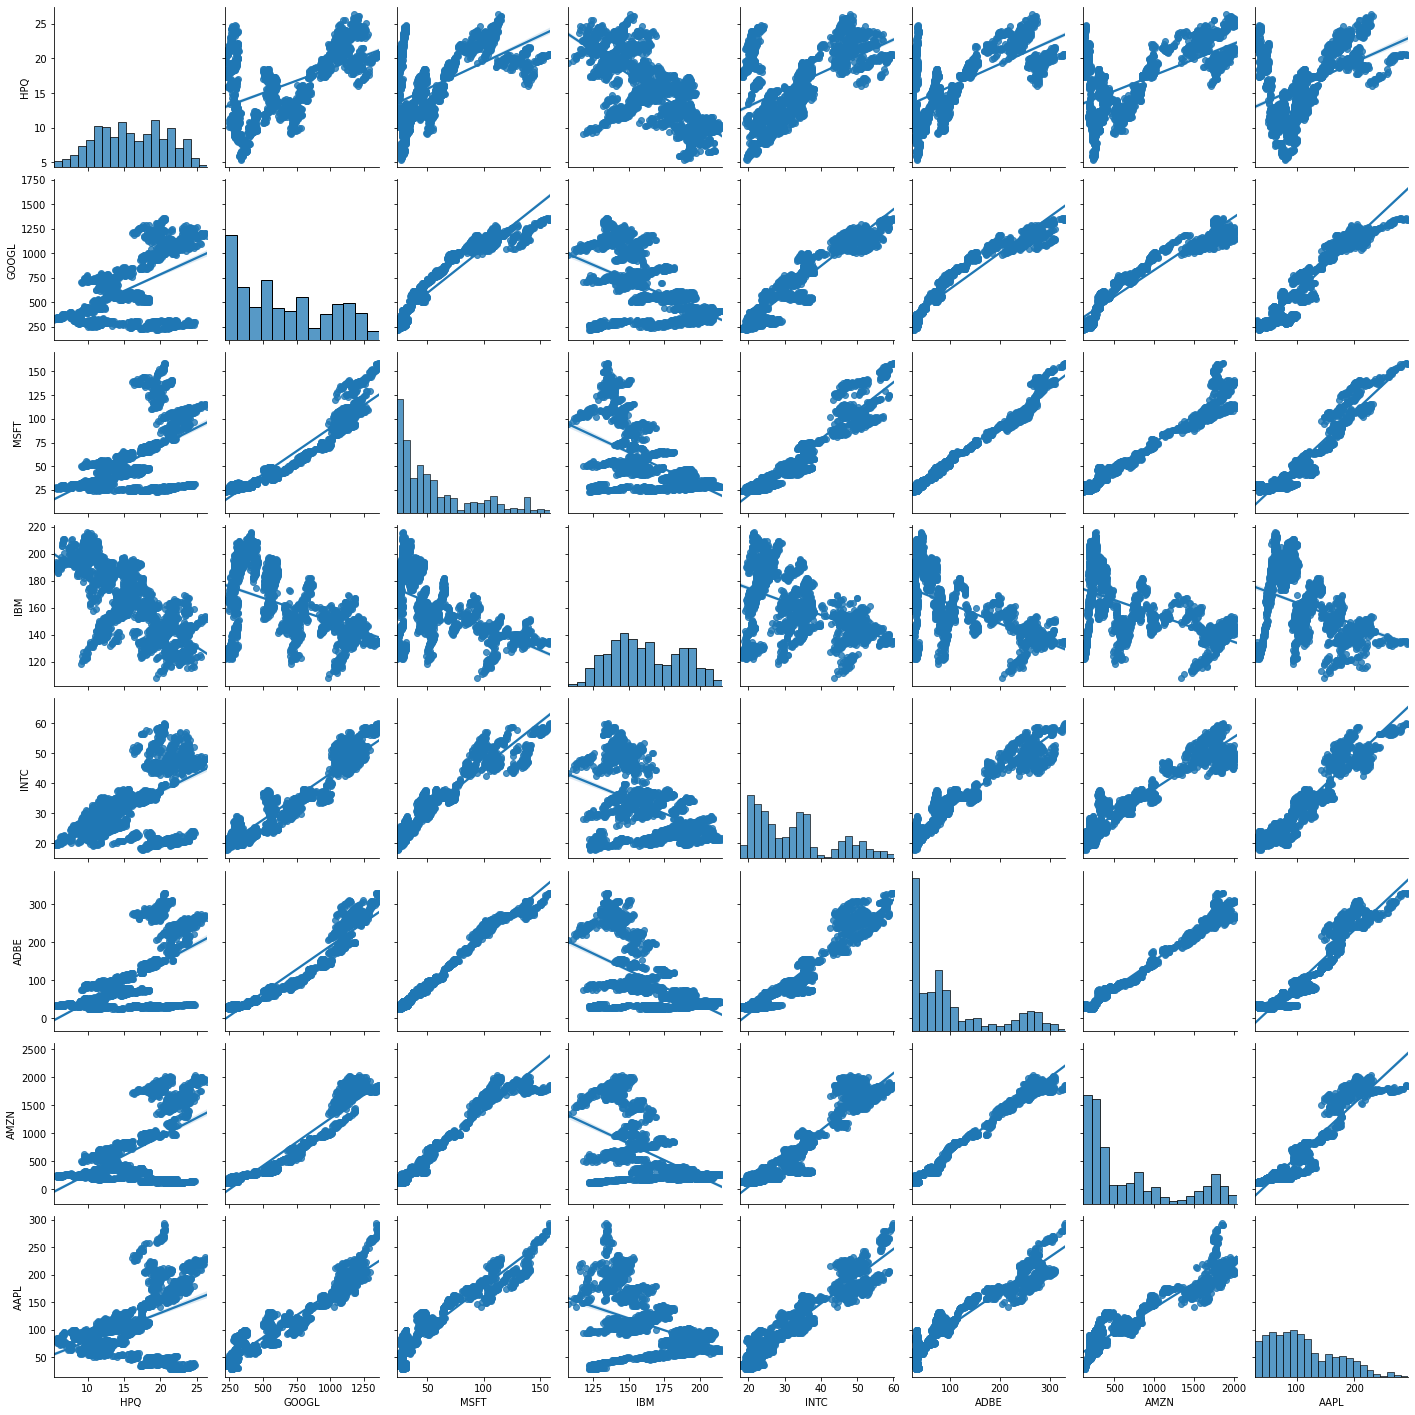

In [16]:
#Regression plot
sns.pairplot(stock_data,kind='reg')
plt.show()

*Plot the time series data of some variables.*

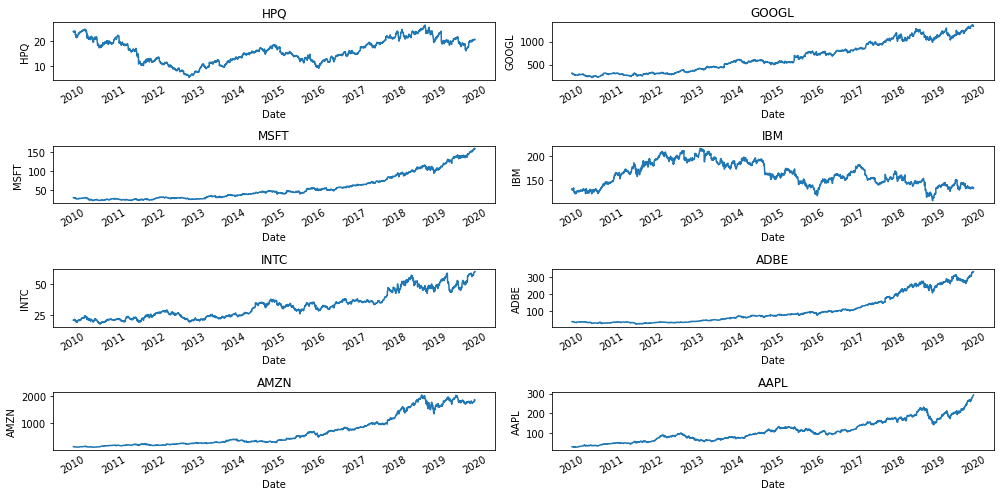

In [17]:
#From https://www.relataly.com/
df_plot = stock_data.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

*Split the data (e.g 0.7/0.3) and prepare the data for training and testing. Note that we will try to make prediction two days ahead (hint: shift the targeted variables two days backward to use as label). Clear indicates which variables are used as predictors in your code and explanation.*

In [18]:
#Creating time-shifted data
horizon = 1
target_meas = ['AAPL']
df_targets = stock_data['AAPL'].shift(-horizon)
df_stock_data = stock_data.copy()

In [19]:
#Time-shifted data
org = pd.concat([stock_data['AAPL'].head(horizon + 5)], keys=['Original series'], axis=1)
nhead = pd.concat([df_targets.head(5)], keys=['Target Label Values'], axis=1)
display_side_by_side(org, nhead)

,Original series
Date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
2010-01-11,30.015715
,Target Label Values
Date,
2010-01-04,30.625713


In [20]:
# Correct predictors x and targets/labels y for the horizon shift
new_df_stock_data = df_stock_data.drop(['HPQ','IBM'],axis=1).copy()
x_data = new_df_stock_data.values[0:-horizon].copy()
y_data = df_targets.values[:-horizon].reshape(-1,1)

# Calculate training and testing partition sizes
num_data = len(x_data)
train_split = 0.7
val_split = 0.3
num_train1 = int(train_split * num_data)
num_test = num_data - num_train1
num_val = int(val_split * num_train1)

num_train = num_train1-num_val


# Define boundaries for training and testing
x_train = x_data[0:num_train]
x_val = x_data[num_train:num_train+num_val]
x_test = x_data[num_train+num_val:]
y_train = y_data[0:num_train]
y_val = y_data[num_train:num_train+num_val]
y_test = y_data[num_train+num_val:]

# Identify time events to be used in training
num_x_events = x_data.shape[1]
num_y_events = y_data.shape[1]

print("Train data shape:", x_train.shape, ", Val data shape:", x_val.shape,", Test data shape:" ,x_test.shape)
print("Train labels shape:", y_train.shape, ", Val labels shape:", y_val.shape,", Test labels shape:", y_test.shape)

Train data shape: (1232, 6) , Val data shape: (528, 6) , Test data shape: (755, 6)
Train labels shape: (1232, 1) , Val labels shape: (528, 1) , Test labels shape: (755, 1)


In [21]:
#Scaling data
x_scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(x_data)
x_train_scaled = x_scaler.transform(x_train).clip(0, 1)
x_val_scaled = x_scaler.transform(x_val).clip(0, 1)
x_test_scaled = x_scaler.transform(x_test).clip(0, 1)
print("After train x scaling - Min:", np.min(x_train_scaled), ", Max:", np.max(x_train_scaled))
print("After test x scaling - Min:", np.min(x_test_scaled), ", Max:", np.max(x_test_scaled))

After train x scaling - Min: 0.0 , Max: 0.43103041571068745
After test x scaling - Min: 0.26015362023084576 , Max: 1.0


In [22]:
#Scaling labels
y_scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(y_data)
y_train_scaled = y_scaler.transform(y_train).clip(0, 1)
y_val_scaled = y_scaler.transform(y_val).clip(0, 1)
y_test_scaled = y_scaler.transform(y_test).clip(0, 1)
print("After train x scaling - Min:", np.min(y_train_scaled), ", Max:", np.max(y_train_scaled))
print("After test x scaling - Min:", np.min(y_test_scaled), ", Max:", np.max(y_test_scaled))

After train x scaling - Min: 0.0 , Max: 0.34255969595025826
After test x scaling - Min: 0.3320042983686409 , Max: 1.0


In [23]:
#Expanding validation and test data on 0 axis
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

test_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [24]:
#Creating batches
#Process 30 sequences before updating the model.
batch_size = 60 
#The length of each time series sequences/input dimenions.
sequence_length = 90
#Creating batch generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
generator

x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(60, 90, 6)
(60, 90, 1)


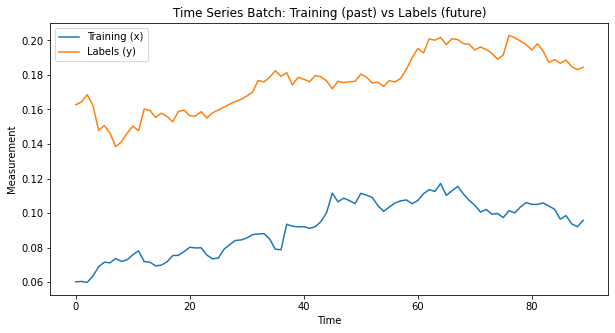

In [25]:
plot_batch(x_batch,y_batch,batch=0,column=1)

<a id = "cell_model"></a>
## 3. Model Construction

*Provide code to create your deep learning models in this section. Create one forecasting model using a Recurrent Neural Network, such as vanilla RNN, LSTM and GRU. Note: Your models should not be exactly the same as the models, which were already included in the weekly practical contents.*

*For all models, use mean_squared_error (MSE) as the loss function, and set the number of epochs to be 100, steps_per_epoch to be 60 and warmup_steps to be 7*

*Once the models are defined, create executable models and visualize their architecture. Hint: use model.summary() function*.

In [26]:
epochs = 100
steps_per_epoch = 60
warmup_steps = 7 # For custom loss function

**Base LSTM**

In [27]:
def base_lstm(num_x_events, num_y_events):
    model = Sequential()
    model.add(LSTM(units=16,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(LSTM(units=32,
                  return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='linear'))    
    return(model)

lstm_base = base_lstm(num_x_events, num_y_events)
lstm_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 16)          1472      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 16)          64        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32)          128       
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 7,969
Trainable params: 7,873
Non-trainable params: 96
_________________________________________________________________


**Regularized LSTM**

In [28]:
def reg_lstm(num_x_events, num_y_events):
    model = Sequential()
    model.add(LSTM(units=8,
                  return_sequences=True, kernel_regularizer = 'l2',
                  input_shape=(None, num_x_events,)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(LSTM(units=16,
                  return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(units=32))
    model.add(Dropout(0.1))
    model.add(Dense(num_y_events, activation='linear'))    
    return(model)

lstm_reg = reg_lstm(num_x_events, num_y_events)
lstm_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 8)           480       
_________________________________________________________________
dropout (Dropout)            (None, None, 8)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 8)           32        
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 16)          1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 16)          64        
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)         

**Regularized LSTM with sigmoid activation and Adam optimizer**

In [29]:
def reg_lstm_sig_adam(num_x_events, num_y_events):
    model = Sequential()
    model.add(LSTM(units=8,
                  return_sequences=True, kernel_regularizer = 'l2',
                  input_shape=(None, num_x_events,)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(LSTM(units=16,
                  return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(units=32))
    model.add(Dropout(0.1))
    model.add(Dense(num_y_events, activation='sigmoid'))    
    return(model)

lstm_reg_sig_adam = reg_lstm_sig_adam(num_x_events, num_y_events)
lstm_reg_sig_adam.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 8)           480       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 8)           32        
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 16)          1600      
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 16)          64        
_________________________________________________________________
dense_3 (Dense)              (None, None, 32)         

**Base GRU**

In [30]:
def base_gru(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=16,
                  return_sequences=True,
                  input_shape=(None, num_x_events,)))
    model.add(BatchNormalization())
    model.add(GRU(units=32,
                  return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='linear'))    
    return(model)

gru_base = base_gru(num_x_events, num_y_events)
gru_base.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 16)          1152      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 16)          64        
_________________________________________________________________
gru_1 (GRU)                  (None, None, 32)          4800      
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 32)          128       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           33        
Total params: 6,177
Trainable params: 6,081
Non-trainable params: 96
_________________________________________________________________


**Regularized GRU**

In [31]:
def reg_gru(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=16,
                  return_sequences=True,kernel_regularizer='l2',
                  input_shape=(None, num_x_events,)))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())
    model.add(GRU(units=32,
                  return_sequences=True,kernel_regularizer='l2'))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())    
    model.add(Dense(units=32))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='linear'))    
    return(model)

gru_reg = reg_gru(num_x_events, num_y_events)
gru_reg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 16)          1152      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 16)          64        
_________________________________________________________________
gru_3 (GRU)                  (None, None, 32)          4800      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 32)          128       
_________________________________________________________________
dense_6 (Dense)              (None, None, 32)         

**Regularized GRU with sigmoid activation and Adam optimizer**

In [32]:
def reg_gru_sig_adam(num_x_events, num_y_events):
    model = Sequential()
    model.add(GRU(units=16,
                  return_sequences=True,kernel_regularizer='l2',
                  input_shape=(None, num_x_events,)))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())
    model.add(GRU(units=32,
                  return_sequences=True,kernel_regularizer='l2'))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())    
    model.add(Dense(units=32))
    model.add(Dropout(0.20))
    model.add(BatchNormalization())
    model.add(Dense(num_y_events, activation='sigmoid'))    
    return(model)

gru_reg_sig_adam = reg_gru_sig_adam(num_x_events, num_y_events)
gru_reg_sig_adam.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 16)          1152      
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 16)          64        
_________________________________________________________________
gru_5 (GRU)                  (None, None, 32)          4800      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 32)          128       
_________________________________________________________________
dense_8 (Dense)              (None, None, 32)         

<a id = "cell_execution"></a>
## 4. Model Execution

*This section is to provide code to fit the models. Record and plot the history of training and validation. Report the performance (mean_absolute_error and loss) of the trained model on the both the training and the test sets.*<br>

**LSTM base mode**

In [33]:
lstm_base.compile(loss=loss_mse_warmup,optimizer=RMSprop(learning_rate=0.001),
                      metrics=['mae'])

perform_indics = lstm_base.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)

# Start collecting history, in case we train the model iteratively
rnn_hist = start_hist()

# Add performance history
rnn_hist = collect_hist(rnn_hist, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 13s 56ms/step - loss: 0.0494 - mae: 0.1736 - val_loss: 0.0174 - val_mae: 0.1265
Epoch 2/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0160 - mae: 0.1111 - val_loss: 0.0118 - val_mae: 0.0998
Epoch 3/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0127 - mae: 0.0996 - val_loss: 0.0070 - val_mae: 0.0711
Epoch 4/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0096 - mae: 0.0846 - val_loss: 0.0044 - val_mae: 0.0632
Epoch 5/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0083 - mae: 0.0797 - val_loss: 0.0126 - val_mae: 0.0958
Epoch 6/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0067 - mae: 0.0722 - val_loss: 0.0079 - val_mae: 0.0763
Epoch 7/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0059 - mae: 0.0681 - val_loss: 0.0042 - val_mae: 0.0586
Epoch 8/100
60/60 [==============================] - 2s 39ms/step - loss: 0

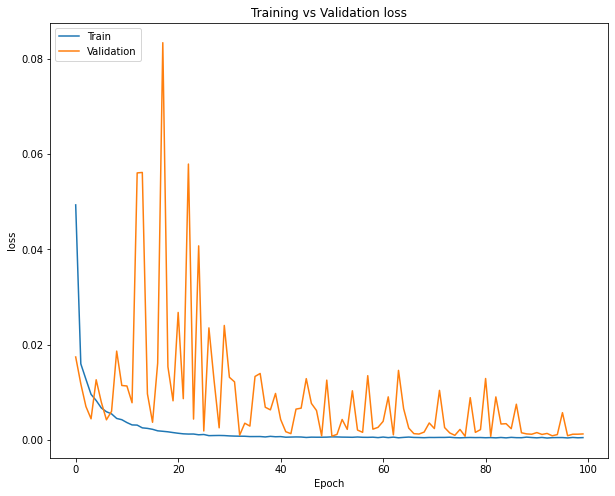

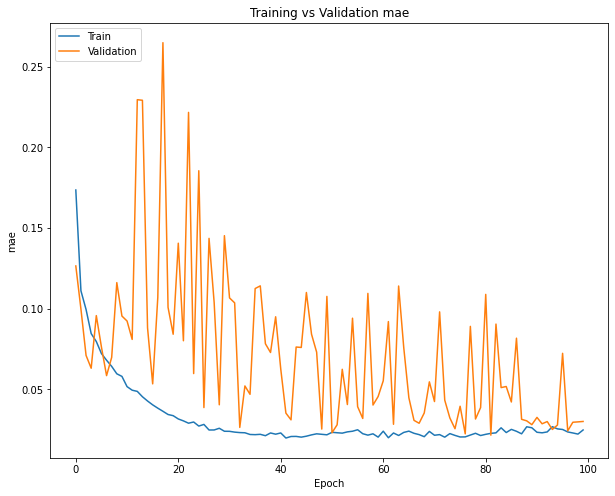

In [34]:
#Plotting history
plot_hist(rnn_hist, xsize=10, ysize=8)

In [35]:
#Train performance
train_perf = lstm_base.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, lstm_base.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 977ms/step - loss: 7.4904e-04 - mae: 0.0209
loss: 0.00075
mae: 0.02091


In [36]:
#Test performance
test_perf = lstm_base.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, lstm_base.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 0.2307 - mae: 0.4366
loss: 0.23070
mae: 0.43658


**Regularized LSTM**

In [37]:
lstm_reg.compile(loss=loss_mse_warmup,optimizer=RMSprop(learning_rate=0.001),
                      metrics=['mae'])

perform_indics = lstm_reg.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)
# Start collecting history, in case we train the model iteratively
rnn_hist1 = start_hist()

# Add performance history
rnn_hist1 = collect_hist(rnn_hist1, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 8s 57ms/step - loss: 0.3127 - mae: 0.3344 - val_loss: 0.1128 - val_mae: 0.1913
Epoch 2/100
60/60 [==============================] - 2s 40ms/step - loss: 0.1030 - mae: 0.1472 - val_loss: 0.0763 - val_mae: 0.1674
Epoch 3/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0500 - mae: 0.0847 - val_loss: 0.0565 - val_mae: 0.1723
Epoch 4/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0252 - mae: 0.0591 - val_loss: 0.0414 - val_mae: 0.1680
Epoch 5/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0115 - mae: 0.0441 - val_loss: 0.0381 - val_mae: 0.1800
Epoch 6/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0045 - mae: 0.0318 - val_loss: 0.0340 - val_mae: 0.1772
Epoch 7/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0015 - mae: 0.0228 - val_loss: 0.0325 - val_mae: 0.1756
Epoch 8/100
60/60 [==============================] - 2s 40ms/step - loss: 7.

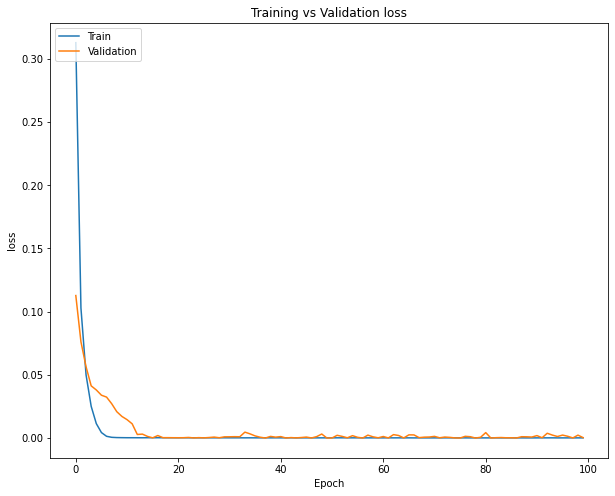

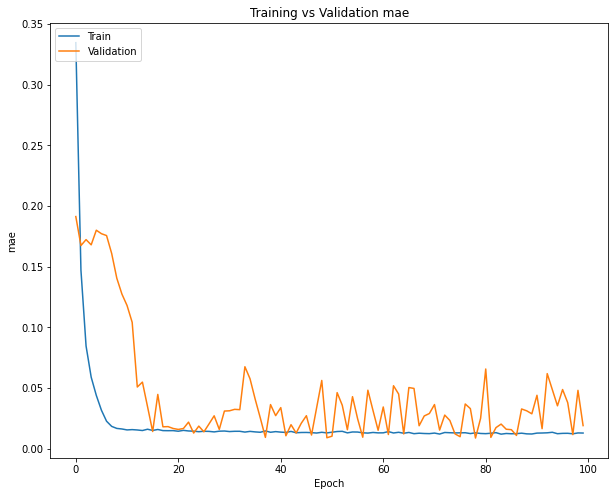

In [38]:
#Plotting history
plot_hist(rnn_hist1, xsize=10, ysize=8)

In [39]:
#Train performance
train_perf = lstm_reg.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, lstm_reg.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 1.0846e-04 - mae: 0.0073
loss: 0.00011
mae: 0.00725


In [40]:
#Test performance
test_perf = lstm_reg.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, lstm_reg.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 7.7185e-04 - mae: 0.0218
loss: 0.00077
mae: 0.02185


**Regularized LSTM - Sigmoid and Adam optimizer**

In [41]:
lstm_reg_sig_adam.compile(loss=loss_mse_warmup,optimizer=Adam(learning_rate=0.001),
                      metrics=['mae'])

perform_indics = lstm_reg_sig_adam.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)
# Start collecting history, in case we train the model iteratively
rnn_hist2 = start_hist()

# Add performance history
rnn_hist2 = collect_hist(rnn_hist2, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 8s 54ms/step - loss: 0.1867 - mae: 0.2894 - val_loss: 0.0752 - val_mae: 0.0316
Epoch 2/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0850 - mae: 0.1674 - val_loss: 0.0640 - val_mae: 0.1248
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0455 - mae: 0.1141 - val_loss: 0.0532 - val_mae: 0.1501
Epoch 4/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0279 - mae: 0.0999 - val_loss: 0.0423 - val_mae: 0.1517
Epoch 5/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0175 - mae: 0.0929 - val_loss: 0.0338 - val_mae: 0.1470
Epoch 6/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0108 - mae: 0.0867 - val_loss: 0.0260 - val_mae: 0.1348
Epoch 7/100
60/60 [==============================] - 2s 37ms/step - loss: 0.0069 - mae: 0.0818 - val_loss: 0.0213 - val_mae: 0.1275
Epoch 8/100
60/60 [==============================] - 2s 38ms/step - loss: 0.

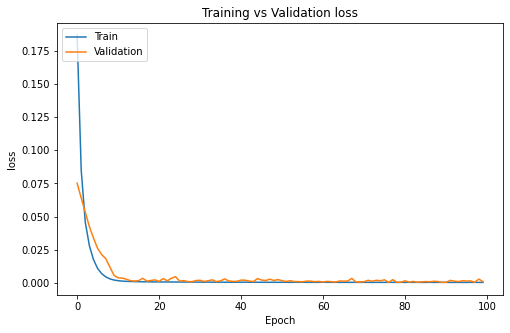

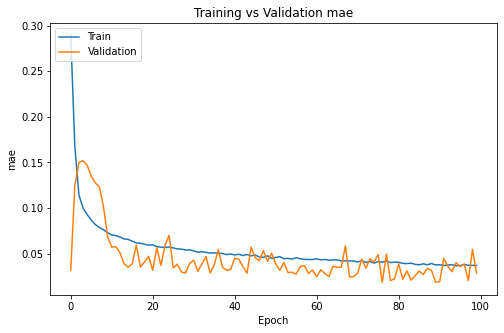

In [42]:
#Plotting history
plot_hist(rnn_hist2, xsize=8, ysize=5)

In [43]:
#Train performance
train_perf = lstm_reg_sig_adam.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, lstm_reg_sig_adam.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 1.1918e-04 - mae: 0.0095
loss: 0.00012
mae: 0.00953


In [44]:
#Test performance
test_perf = lstm_reg_sig_adam.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, lstm_reg_sig_adam.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 1s/step - loss: 0.0560 - mae: 0.2085
loss: 0.05595
mae: 0.20855


**GRU base model**

In [45]:
gru_base.compile(loss=loss_mse_warmup,optimizer=RMSprop(learning_rate=0.001),
                      metrics=['mae'])

perform_indics = gru_base.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)

# Start collecting history, in case we train the model iteratively
rnn_hist3 = start_hist()

# Add performance history
rnn_hist3 = collect_hist(rnn_hist3, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 8s 53ms/step - loss: 0.0330 - mae: 0.1447 - val_loss: 0.0361 - val_mae: 0.1880
Epoch 2/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0098 - mae: 0.1032 - val_loss: 0.0251 - val_mae: 0.1564
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0096 - mae: 0.0988 - val_loss: 0.0144 - val_mae: 0.1176
Epoch 4/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0079 - mae: 0.0932 - val_loss: 0.0147 - val_mae: 0.1190
Epoch 5/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0069 - mae: 0.0903 - val_loss: 0.0181 - val_mae: 0.1313
Epoch 6/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0058 - mae: 0.0865 - val_loss: 0.0077 - val_mae: 0.0847
Epoch 7/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0052 - mae: 0.0826 - val_loss: 0.0070 - val_mae: 0.0756
Epoch 8/100
60/60 [==============================] - 2s 38ms/step - loss: 0.

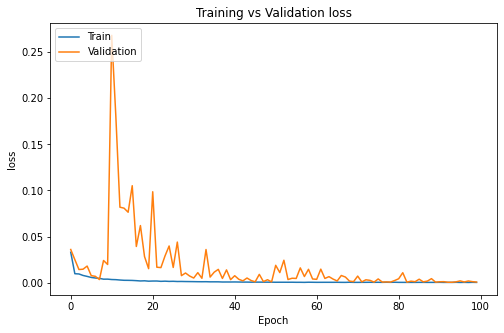

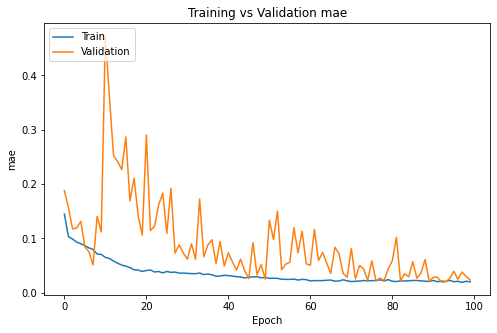

In [46]:
#Plotting history
plot_hist(rnn_hist3, xsize=8, ysize=5)

In [47]:
#Train performance
train_perf = gru_base.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, gru_base.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 899ms/step - loss: 4.8397e-04 - mae: 0.0212
loss: 0.00048
mae: 0.02118


In [48]:
#Test performance
test_perf = gru_base.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, gru_base.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 940ms/step - loss: 0.0860 - mae: 0.2608
loss: 0.08602
mae: 0.26079


**Regularized GRU**

In [49]:
gru_reg.compile(loss=loss_mse_warmup,optimizer=RMSprop(learning_rate=0.001, decay = 0.01),
                      metrics=['mae'])

perform_indics = gru_reg.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)
# Start collecting history, in case we train the model iteratively
rnn_hist4 = start_hist()

# Add performance history
rnn_hist4 = collect_hist(rnn_hist4, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 8s 56ms/step - loss: 0.6495 - mae: 0.4338 - val_loss: 0.2639 - val_mae: 0.1659
Epoch 2/100
60/60 [==============================] - 2s 41ms/step - loss: 0.4083 - mae: 0.3366 - val_loss: 0.1988 - val_mae: 0.1852
Epoch 3/100
60/60 [==============================] - 2s 41ms/step - loss: 0.2884 - mae: 0.2946 - val_loss: 0.1466 - val_mae: 0.1581
Epoch 4/100
60/60 [==============================] - 2s 41ms/step - loss: 0.2003 - mae: 0.2561 - val_loss: 0.1306 - val_mae: 0.1920
Epoch 5/100
60/60 [==============================] - 2s 41ms/step - loss: 0.1324 - mae: 0.2079 - val_loss: 0.1013 - val_mae: 0.1671
Epoch 6/100
60/60 [==============================] - 3s 42ms/step - loss: 0.0879 - mae: 0.1624 - val_loss: 0.0769 - val_mae: 0.1408
Epoch 7/100
60/60 [==============================] - 2s 42ms/step - loss: 0.0616 - mae: 0.1313 - val_loss: 0.0577 - val_mae: 0.1159
Epoch 8/100
60/60 [==============================] - 2s 41ms/step - loss: 0.

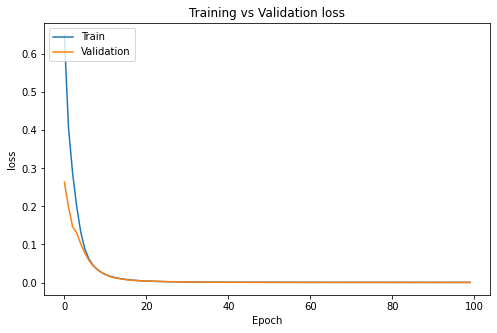

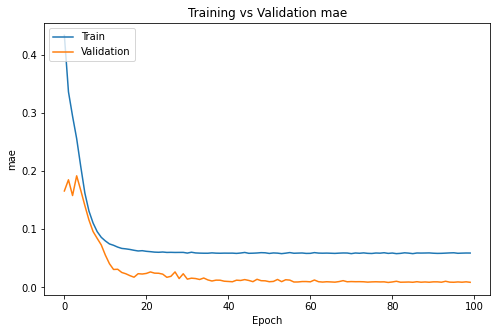

In [50]:
#Plotting history
plot_hist(rnn_hist4, xsize=8, ysize=5)

In [51]:
#Train performance
train_perf = gru_reg.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, gru_reg.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 942ms/step - loss: 1.0837e-04 - mae: 0.0061
loss: 0.00011
mae: 0.00613


In [52]:
#Test performance
test_perf = gru_reg.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, gru_reg.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 934ms/step - loss: 3.8640e-04 - mae: 0.0134
loss: 0.00039
mae: 0.01343


**Regularized GRU with Sigmoid activation and Adam optimizer**

In [53]:
gru_reg_sig_adam.compile(loss=loss_mse_warmup,optimizer=Adam(learning_rate=0.001, decay = 0.01),
                      metrics=['mae'])

perform_indics = gru_reg_sig_adam.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data)
# Start collecting history, in case we train the model iteratively
rnn_hist5 = start_hist()

# Add performance history
rnn_hist5 = collect_hist(rnn_hist5, perform_indics.history)

Epoch 1/100
60/60 [==============================] - 8s 54ms/step - loss: 0.4181 - mae: 0.3155 - val_loss: 0.2324 - val_mae: 0.0773
Epoch 2/100
60/60 [==============================] - 2s 39ms/step - loss: 0.2563 - mae: 0.2506 - val_loss: 0.1526 - val_mae: 0.0326
Epoch 3/100
60/60 [==============================] - 2s 40ms/step - loss: 0.1752 - mae: 0.2097 - val_loss: 0.1129 - val_mae: 0.0401
Epoch 4/100
60/60 [==============================] - 2s 40ms/step - loss: 0.1223 - mae: 0.1687 - val_loss: 0.0870 - val_mae: 0.0347
Epoch 5/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0878 - mae: 0.1338 - val_loss: 0.0738 - val_mae: 0.0662
Epoch 6/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0678 - mae: 0.1142 - val_loss: 0.0633 - val_mae: 0.0813
Epoch 7/100
60/60 [==============================] - 2s 40ms/step - loss: 0.0550 - mae: 0.1034 - val_loss: 0.0541 - val_mae: 0.0824
Epoch 8/100
60/60 [==============================] - 2s 40ms/step - loss: 0.

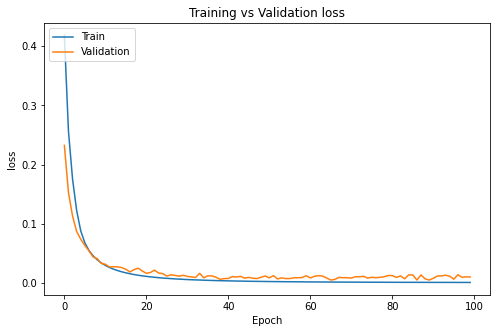

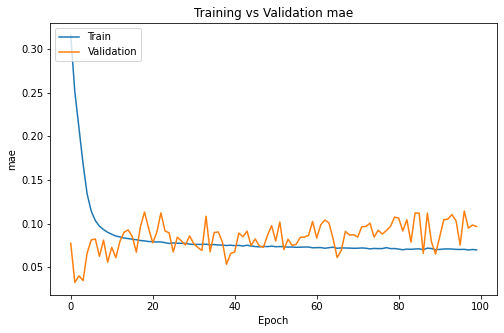

In [54]:
#Plotting history
plot_hist(rnn_hist5, xsize=8, ysize=5)

In [55]:
#Train performance
train_perf = gru_reg_sig_adam.evaluate(x=np.expand_dims(x_train_scaled, axis=0),
                        y=np.expand_dims(y_train_scaled, axis=0))

for res, metric in zip(train_perf, gru_reg_sig_adam.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 928ms/step - loss: 6.8986e-04 - mae: 0.0159
loss: 0.00069
mae: 0.01586


In [56]:
#Test performance
test_perf = gru_reg_sig_adam.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
for res, metric in zip(test_perf, gru_reg_sig_adam.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 999ms/step - loss: 0.0697 - mae: 0.2593
loss: 0.06965
mae: 0.25929


<a id = "cell_report"></a>
## 5. Prediction

*Generate prediction: the predicted and true output time series of the targeted variable.*

**Base LSTM**

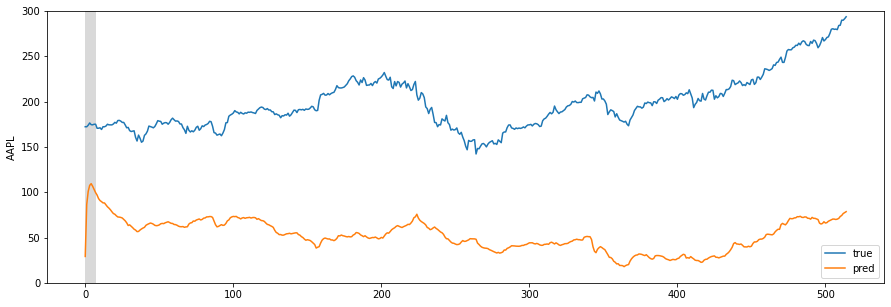

In [57]:
plot_comparison(start_idx=2000, length=600,ylim=(0,300),model=lstm_base)

**Regularized LSTM**

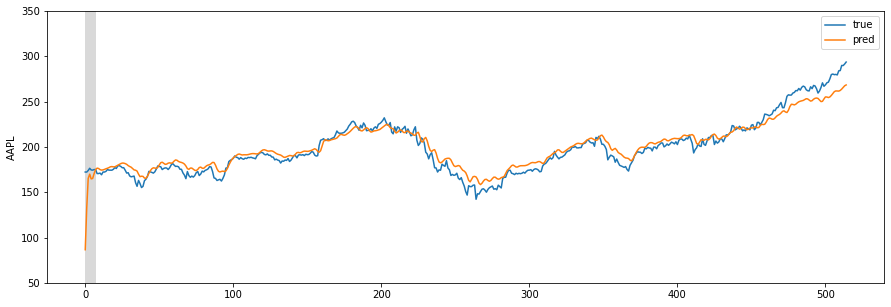

In [63]:
plot_comparison(start_idx=2000, length=600,ylim=(50,350),model=lstm_reg)

**Regularized LSTM with Sigmoid activation and Adam optimizer**

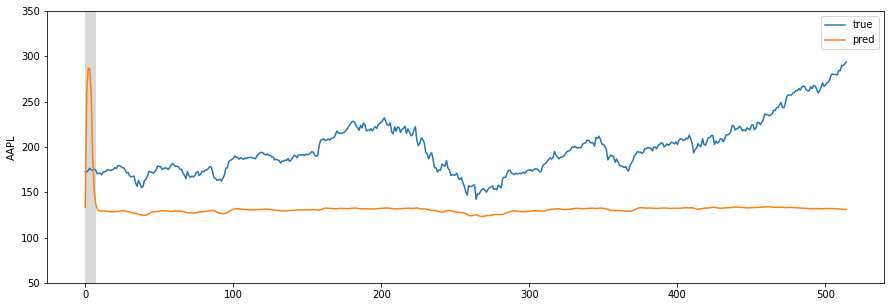

In [59]:
plot_comparison(start_idx=2000, length=600,ylim=(50,350),model=lstm_reg_sig_adam)

**Base GRU**

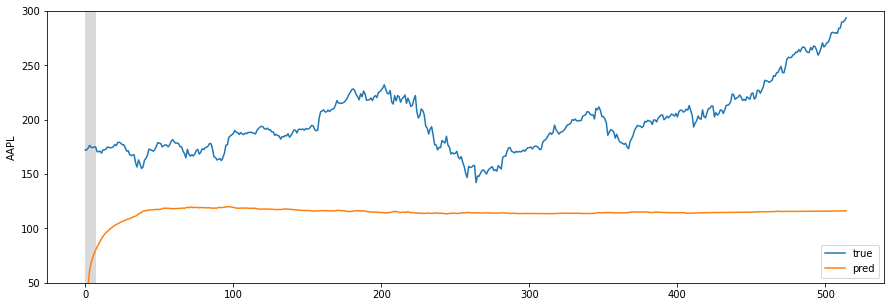

In [60]:
plot_comparison(start_idx=2000, length=600,ylim=(50,300),model=gru_base)

**Regularized GRU**

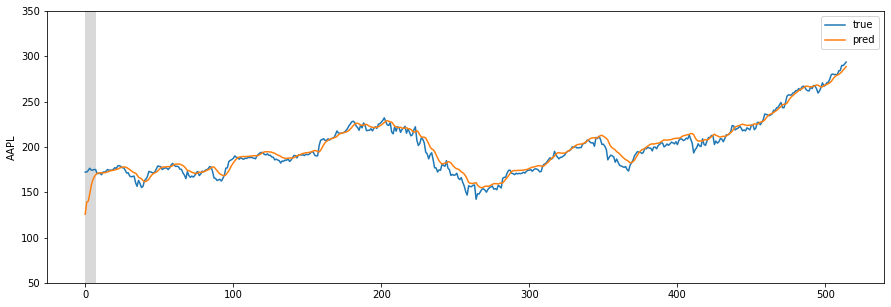

In [61]:
plot_comparison(start_idx=2000, length=600,ylim=(50,350),model=gru_reg)

**Regularized GRU with Sigmoid activation and Adam optimizer**

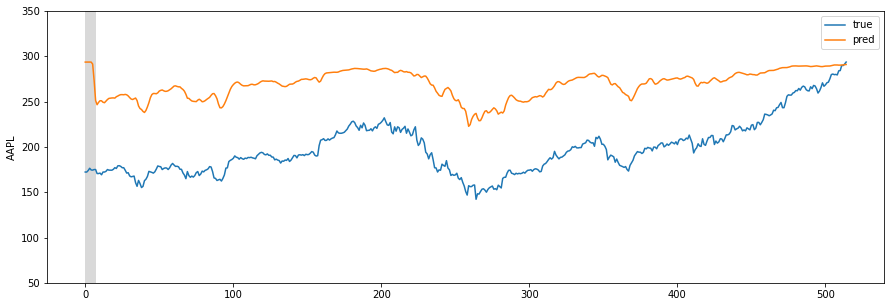

In [62]:
plot_comparison(start_idx=2000, length=600,ylim=(50,350),model=gru_reg_sig_adam)

**Performance summary**

| Model# |  Train loss | Test loss | Train MAE  | Test MAE  | Activation | Optimizer |
| :-: | -: | -: | -: | -: | -: | -: |
| Base LSTM | 0.0013 | 0.0392  | 0.0362  | 0.1965  | linear  | RMSProp  |
| Regularized LSTM | 0.0002 | 0.0092  | 0.0019  | 0.0393  | linear  | RMSProp  |
| Regularized LSTM - Sig - Adam | 0.0004 | 0.0465  | 0.0176  | 0.1869  | sigmoid  | Adam  |
| Base GRU| 0.0007 | 0.0070  | 0.0267  | 0.0757  | linear  | RMSProp  |
| Regularized GRU | 0.0001 | 0.0004  | 0.0059  | 0.0127  | linear  | RMSProp  | 
| Regularized GRU - Sig - Adam | 0.0007 | 0.0553  | 0.016  | 0.2315  | sigmoid  | Adam  |

<br>

**Summary**

In this experiment, closing price of 8 leading IT/IT enabled services company is given. AAPL was considered as dependent variable. In model, AAPL is also considered as independent variable as past 90 days was used to forecast 91st day's price for AAPL. This ensures to capture cross-correlation with stocks within same industry and auto-corelation. Dropping HPQ and IBM considerable improved model's performance and justified by weak correlation with AAPL. Use of scaler was tricky. Financial timeseries often has mean, variance, and co-variance change overtime. This changes the descriptive statistics like range which is important in MinMax scaler. Thus, transforming training, validation, and test dataset with scaler fitted on entired dataset considerable improved accuracy.

Six models were experimented. As dataset is not large enough, GRU models outperformed LSTM models. RMSprop optimizer and Linear activation combination outperformed Adam optimizer and Sigmoid activation combination. Best model was regularized GRU model with decay of 0.01 in learning rate. Followed regularized LSTM. Both the models provided good fit with better predictions. Rest of the models suffered from overfittting.